---

## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Nombre completo**
* Carné: **B12345**
* Grupo: **1**


# `P3` - *La demanda energética de electricidad en Costa Rica, parte II*

> Esta actividad extiende el análisis y modelado realizados anteriormente sobre la demanda eléctrica del país, por hora, a partir de una base de datos del Instituto Costarricense de Electricidad del 2019. El énfasis ahora es encontrar las relaciones que existen entre los modelos de cada hora.

---
* Elaboración de nota teórica y demostración: **Jeaustin Sirias Chacón**, como parte de IE0499 - Proyecto Eléctrico: *Estudio y simulación de aplicaciones de la teoría de probabilidad en la ingeniería eléctrica*.
* Revisión: **Fabián Abarca Calderón**


---
## 1. - Introducción

Ampliando el análisis de los datos elaborado en el Proyecto 2 (`P2`), lo cierto es los sistemas complejos de la realidad, no suelen contener solo una variable aleatoria, sino, múltiples y es por dicha razón que las variables aleatorias múltiples también pueden ser discretas o continuas en función de su espacio muestral $S$; así, ahora vale la pena hacer referencia a un **vector aleatorio** que contiene una familia de las variables aleatorias en cuestión y es usual expresar este hecho como:

$$
\vec{X} = (X_1, X_2, X_3, \ldots, X_n)
$$

La novedad de ahora hablar de un conjunto multidimensional $\vec{X}$ tiene ciertas implicaciones. Quizá lo más relevante puede hallarse desde la óptica del espacio muestral del vector aleatorio, pues se sabe que ahora ya no alberga, como tradicionalmente ocurría, solo una variable aleatoria. Este hecho en específico diversifica en gran medida **el sentido espacial**; por ejemplo, supóngase que hay cierto vector aleatorio $\vec{V} = (X, Y)$ cuya composición espacial consta de dos dimensiones (puesto que, en efecto, hay dos variables aleatorias en $\vec{V}$). Hacer referecia ahora a un "plano" cobra sentido, en especial para evidenciar cualquier par ordenado $(x_i, y_j)$, que representa un punto aleatorio en el plano $XY$. 


<img align='center' src='https://i.imgur.com/NEkKuHl.jpg' width ="700"/>

Ahora bien, ¿qué ocurre cuando $\vec{V}$ es $n$-dimensional?, ¿podría ser tan sencillo de manipular cinco o siete dimensiones, ocurre con dos?, ¿se puede?. En este proyecto programado se abordará el eje temático de las variables aleatorias multidimensionales desde un enfoque práctico e interactivo para conocer las relaciones que existen entre los múltiples intervalos de demanda energética como un sistema.


---
## 2. - La librería `fitter` para la determinación de modelos probabilísticos

Hasta el momento en el curso se han encontrado los parámetros de mejor ajuste entre un conjunto de datos (una "muestra") y un modelo probabilístico particular, quizá elegido *arbitrariamente* o por un desarrollado sentido de la intuición, del tipo: "hmm, esa distribución me parece exponencial". Sin embargo, está claro que algunos modelos hacen una mejor descripción de los datos que otros, y no siempre se puede encontrar "a puro ojo". En el proyecto anterior se construyó una funcion programada específicamente para hallar el modelo de mejor ajuste para una población específica de muestras, para evidenciar una aplicación práctica de las variables aleatorias. Unas pocas distribuciones eran sometidas a prueba (distribución normal, gamma, beta, Burr tipo XII, etc) como candidatas al mejor modelo de ajuste; no obstante, el módulo `stats` de la biblioteca SciPy ofrece soporte hasta para 80 distribuciones distintas, y sería algo tedioso (y hasta brusco en términos del tiempo de ejecución de Python). Para ello la biblioteca [fitter](https://fitter.readthedocs.io/en/latest/) será introducida en esta ocasión. Tal cual su nombre lo indica (ajustador, en español), esta herramienta provee módulos dedicados a probar todas las distribuciones de `stats` (si así se le indica), concluyendo, definitivamente "la mejor" distribución y sus parámetros de ajuste del mejor modelo. El interés de implementar el uso de `fitter` es aumentar el margen de "confianza" respecto a lo que se considera "el mejor modelo" para una población de muestras. Los métodos a emplear del módulo `Fitter` (*Fitter* y *fitter* hacen referencia a términos distintos) son los siguientes:

```python
from fitter import Fitter # Invocación de la clase Fitter

f = Fitter()              # Para instanciar la clase
f.fit()                   # Para evaluar las 80 distribuciones
f.get_best()              # Para hallar el mejor modelo 
```

---
## 3. - Funciones útiles y otras novedades

Para esta ocasión es útil (y necesario) implementar ciertas funciones que simplifiquen las asignaciones a resolver, no obstante, se observará que algunas de ellas "heredan" características e instrucciones que contenían las funciones en el anterior proyecto. Se contará con las siguientes funciones a saber:

* `extraer_datos(archivo_json, hora)`: Importa la base de datos completa y devuelve los datos de potencia a la hora indicada en un *array* de valores. Esta función es idéntica a la del proyecto anterior.

* `distribucion_conjunta(X, Y, bins)`: Pide por parámetros dos variables aleatorias $X$, $Y$ y el número de divisones (bins) correspondientes a dos intervalos horarios. Visualiza un histograma bivariado y retorna los datos de la función bivariada discreta en dos formatos distintios.

* `evaluar_modelos(datos)`: Encuentra la distribución de mejor ajuste y retorna los parámetros del modelo correspondiente para una población de muestras.

* `densidad_marginal()`: 

* `energia_diaria(archivo_json)`: Importa la base de datos completa en formato **JSON** y calcula la energía diaria usando [la Regla del Trapecio](https://es.wikipedia.org/wiki/Regla_del_trapecio) y retorna un vector con muestras diarias de energía.

* `parametros_energia(vector_energia)`: Recibe por parámetro un vector de energía diaria y retorna la media y la desviación estándar basadas en las muestras ingresadas.

Las llamadas a bibliotecas de Python, de interés para este proyecto programado, son:

```python
import numpy as np               # Para manipular datos de interés y calcular resultados
from fitter import Fitter        # Para evaluar el modelo de mejor ajuste en una población
import pandas as pd              # Para manipular y leer la base de datos de demanda en formato JSON
from scipy import stats          # La música de la fiesta
import matplotlib.pyplot as plt  # Para visualizar resultados relevantes
from datetime import datetime    # Manipulación de formatos temporales
```


### 3.1 - Acondicionamiento de la población de muestras


In [14]:
import pandas as pd
import numpy as np
from datetime import datetime

def extraer_datos(archivo_json, hora):
    '''Importa la base de datos completa y devuelve los
    datos de potencia a la hora indicada en un
    array de valores.
    '''
    
    # Cargar el "DataFrame"
    df = pd.read_json(archivo_json) 
    
    # Convertir en un array de NumPy
    datos = np.array(df)                

    # Crear vector con los valores demanda en una hora
    demanda = []

    # Extraer la demanda en la hora seleccionada
    for i in range(len(datos)):
        instante = datetime.fromisoformat(datos[i][0]['fechaHora'])
        if instante.hour == hora:
            demanda.append(datos[i][0]['MW'])

    return demanda

### 3.2 - Parámetros bivariados y modelos de mejor ajuste

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def distribucion_conjunta(X, Y, bins):
    '''
    Pide por parámetros dos variables aleatorias
    X y Y, así como el número de 'bins' o divisiones
    a emplear para construir el histograma bivariado.
    Retorna
    '''
    np.seterr(all='ignore') # ignorar advertencias
    
    # Se inicializa la figura interactiva 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Se obtiene el plano de probabilidades para graficar el hist3D
    hist, xbins, ybins = np.histogram2d(X, Y, bins=bins, normed=False)
    hist = hist / sum(sum(hist))
    xbins = (xbins + np.roll(xbins, -1))[:-1] / 2.0 
    ybins = (ybins + np.roll(ybins, -1))[:-1] / 2.0 
    
    #Formatos de retorno para la funcion de densidad bivariada discreta
    xyp = [[xbins[i], ybins[j], hist[i][j]] for i in range(bins) for j in range(bins)]
    xy = hist 

    # Se construyen los arreglos para el ancho de Bins * Bins barras
    xpos, ypos = np.meshgrid(xbins, ybins, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Se dimensiona el ancho visual de las barras (como un sólido).
    dx = dy = 30 * np.ones_like(zpos)
    dz = hist.ravel() 

    # Se visualiza el histograma 3D
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')
    ax.set_xlabel('La hora 1 (X)')
    ax.set_ylabel('La hora 2 (Y)')
    ax.set_zlabel('Probabilidad')
    plt.show()

    return xyp, xy, xbins, ybins
    

Obsérvese que la función anterior retorna los datos de la función bivariada sobre la base de las variables aleatorias $X$ y $Y$ en dos arreglos distintos `xyp` y `xy`con el objetivo de simplificar la manipulación de datos en las actividades por realizar, y lucen de la siguiente forma, respectivamente:


**El formato xyp:**
```python
    x   y      P
0  x1  y1  0.001
1  x1  y2  0.020
2  x1  y3  0.092
3  x2  y1  0.093
4  x2  y2  0.083
5  x2  y3  0.061
.   .   .    .
.   .   .    .
.   .   .    .
n   xn  yn   Pn
```

**El formato xy:**
```python
      y1      y2      y3      y4     y5     y6    .   .   yn
x1  0.030  0.0400  0.0400  0.0400  0.040  0.040   .   .    .
x2  0.090  0.0056  0.0400  0.0860  0.054  0.004   .   .    .
x3  0.005  0.0450  0.0690  0.0010  0.001  0.060   .   .    .
x4  0.060  0.0230  0.0025  0.0014  0.084  0.050   .   .    .
.     .       .       .       .       .     .
.     .       .       .       .       .     .     .   .    .
.     .       .       .       .       .     .
xn    .       .       .       .       .     .     .   .    .
``` 
En ambos casos, independientemente, se puede interpretar los elementos $x_n$ y $y_n$ (las variables `xbins` y `ybins`) como las divisiones por dimensión (bins). Para este caso ambas dimensiones tendrán siempre la misma cantidad de "bins" por la forma en que ha programado la función `distribucion_conjunta`.



In [16]:
from fitter import Fitter

def evaluar_modelos(datos):
    '''
    Evalúa las 80 distribuciones del módulo stats
    y obtiene el el modelo de mejor ajuste para
    la demanda anual de una hora específica. Retorna
    el nombre de la mejor distribución y una tupla con
    los parámetros del modelo.
    '''
    np.seterr(all='ignore') # ignorar advertencias
    
    # Hallar el mejor ajuste con Fitter
    f = Fitter(datos, timeout=120)
    f.fit()
    ajuste = f.get_best()
    
    for i in ajuste.keys():
        dist, params = i, ajuste[i]

    print('------------\nDistribución\n------------')
    print(dist, '\n')
    print('----------\nParámetros\n----------')
    print(params)

    return dist, params


### 3.3 - Cálculo y contraste de la densidad marginal con un modelo de mejor ajuste

In [17]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import tikzplotlib as tk

def densidad_marginal(xy, bins, dist, params, eje):
    '''
    Se elije eje='x' o eje='y' segun sea el caso para la 
    densidad marginal en Y o en X. El parámetro 'xy' es el
    formato de datos bivariable, 'bins' es el vector de valores
    de potencia xbins o ybins. Los parámetros 'dist' y 'params'
    corresponden al modelo de mejor ajuste retornado por el fitter.
    '''
    np.seterr(all='ignore') # ignorar advertencias
    
    # Hallar la densidad marginal de x o y, según se indique en 'eje'
    if eje == 'x':

        filas = len(xy)
        marginal = [sum(xy[i]) for i in range(filas)]

    elif eje == 'y':

        xy = xy.transpose()
        filas = len(xy)
        marginal = [sum(xy[i]) for i in range(filas)]

    # Visualizar modelo de mejor ajuste
    distro = getattr(stats, dist) 
    d = np.arange(min(bins)*0.96, max(bins)*1.04, 1)
    pdf_plot = distro.pdf(d, *params)
    plt.plot(d, pdf_plot*22, lw=3.5, color='r', label='Fitter')
    
    # Visualizar función de densidad marginal
    plt.bar(bins, marginal, width=12, label='D. Marginal')
    plt.title('Contraste: densidad marginal vs. modelo de mejor ajuste')
    plt.xlabel('Potencia [MW]')
    plt.ylabel('Densidad Probabilística')
    plt.legend()
    tk.save('marginal.tikz')
    plt.show()
    
    return marginal

### 3.4 - Calculando la energía diaria y parámetros relevantes

In [18]:
import pandas as pd
import numpy as np
from datetime import datetime

def energia_diaria(archivo_json):
    '''
    Importa la base de datos completa y devuelve un
    vector con la energía diaria, en MWh.
    '''
    
    # Cargar el "DataFrame"
    df = pd.read_json(archivo_json) 

    # Convertir en un array de NumPy
    datos = np.array(df)  

    # Crear vector con todos los valores horarios de demanda
    demanda = []

    # Extraer la magnitud de la demanda para todas las horas
    for hora in range(len(datos)):
        instante = datetime.fromisoformat(datos[hora][0]['fechaHora'])
        demanda.append(datos[hora][0]['MW'])

    # Separar las magnitudes en grupos de 24 (24 h)
    demanda = np.split(np.array(demanda), len(demanda) / 24)

    #Crear vector para almacenar la enegia a partir de la demanda
    energia = []

    #calcular la energia diaria por la Regla del Trapecio
    for dia in range(len(demanda)):

        E = round(np.trapz(demanda[dia]), 2)
        energia.append(E)

    return energia

In [19]:
import numpy as np

def parametros_energia(vector_energia): # E
    '''
    Calcula los parámetros media y stDev
    en del vector de energía, y los retorna
    '''

    media = np.median(vector_energia)
    desviacion = np.std(vector_energia)

    return media, desviacion #mu, sigma

### 3.5 - Probando las funciones implementadas

Ahora bien, se puede elaborar una breve demostración práctica basada en las funciones anteriormente implementadas, haciendo sus respectivas llamadas:

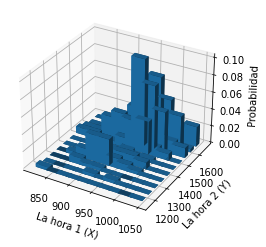

In [20]:
# Se eligen las dos horas que desean estudiarse
hora_1 = extraer_datos('demanda_2019.json', 3) 
hora_2 = extraer_datos('demanda_2019.json', 11) 

# Se ejecuta el análisis bivariado
xyp, xy, xbins, ybins = distribucion_conjunta(hora_1, hora_2, bins = 10)

In [21]:
# Se llama obtiene los parámetros de mejor ajuste para cada hora

dist, params = evaluar_modelos(hora_1)
#_dist, _params = evaluar_modelos(hora_2)

------------
Distribución
------------
genlogistic 

----------
Parámetros
----------
(0.6318766353534495, 952.2292025622228, 19.795927564550382)


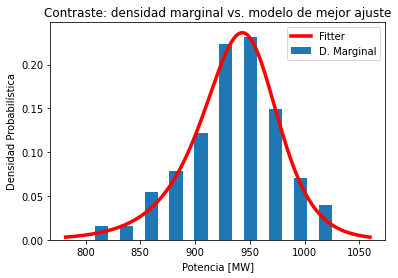

[0.01568627450980392,
 0.01568627450980392,
 0.054901960784313725,
 0.0784313725490196,
 0.12156862745098039,
 0.2235294117647059,
 0.23137254901960785,
 0.14901960784313723,
 0.07058823529411765,
 0.0392156862745098]

In [22]:
# Se contrasta la densidad marginal para cada hora, según su eje
densidad_marginal(xy, xbins, dist, params, eje='x')

---
## 4. - Asignaciones del proyecto

Aquí la introducción

In [23]:
import random

def horas_asignadas(digitos):
    '''Elige una hora A en periodo punta
    y una hora B de los otros periodos,
    con los dígitos del carné como "seed"
    '''
    random.seed(digitos)
    punta = [11, 12, 18, 19, 20]
    valle = [7, 8, 9, 10, 13, 14, 15, 16, 17]
    nocturno = [21, 22, 23, 0, 1, 2, 3, 4, 5, 6]
    otro = valle + nocturno
    HA = punta[random.randrange(0, len(punta))]
    HB = otro[random.randrange(0, len(otro))]
    horas = 'Hora A = {}, hora B = {}'.format(HA, HB)
    return horas

### 4.1. - Función distribución múltiple bivariada

1. Analizar datos bivariados: ($P_X$, $P_15$) (numpy.histogram2d, density=True)
1. Visualizar estos datos (matplotlib)
1. Funciones de densidad marginales (fitter)
1. (X) Prueba de independencia, graficar histograma ("b") versus modelo
1. Valores esperados E(X) y E(Y) de los datos bivariados ("b" y "c")


In [24]:
# 4.1. - Comparación de consumo de potencia

### 4.2. - Independencia estadística de las distribuciones de probabilidad

1. Correlación entre X y Y, E(XY) = R_XY
1. (Sí/No y por qué) Prueba de correlación E(XY) = E(X)E(Y) con una tolerancia del 5%
1. (Cuantificar) Determinación de la covarianza y el índice de correlación de Pearson
1. (Análisis) ¿Qué implica este valor de covarianza?

In [25]:
# 4.2. - Independencia estadística de las distribuciones de probabilidad

### 4.3. - Correlación entre el consumo a distintas horas del día

1. Teorema del límite central en la suma
1. Análisis de consumo de energía semanal


$S_E = X_L + X_K + X_M + X_J + X_V + X_S + X_D \sim \mathcal{N}$

$$
Z = \frac{S_N - \mu_{S_N}}{\sigma_{S_N}} = \frac{S_N - N\mu}{\sigma \sqrt{N}}
$$

In [26]:
# 4.4. - Obtención de los momentos de los modelos

/home/jussc_/.local/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:4523: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intg = integrate.quad(f, -xi, np.pi/2, **intg_kwargs)[0]


---

### Universidad de Costa Rica
#### Facultad de Ingeniería
##### Escuela de Ingeniería Eléctrica

---